# CAB420, Practical 3 - Question 2 Solution
## Multi-Class Classification
In this question we are using the multi-class version of the red wine data, redwine-multiclass.csv, which contains fine-grained quality ratings, but is otherwise the same as the binary data. 

Using this data:
* Train a Random Forest to classify a wine's quality. Select appropriate hyper-parameters for the forest, and evaluate the impact of including class weights.
* Train an ensemble of SVMs to predict a wine's quality. In doing this you should:
  * Train both a one vs one and one vs all model. Comment on differences in performance and training speed.
  * Compare the performance of the two models, while also considering the class imbalance in the data. Explore how the error costs can be changed to improve performance for those classes with limited data.
* Obtain precision, recall and F1 score measures for both classifiers, and compare the results.

In [1]:
# import all the important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


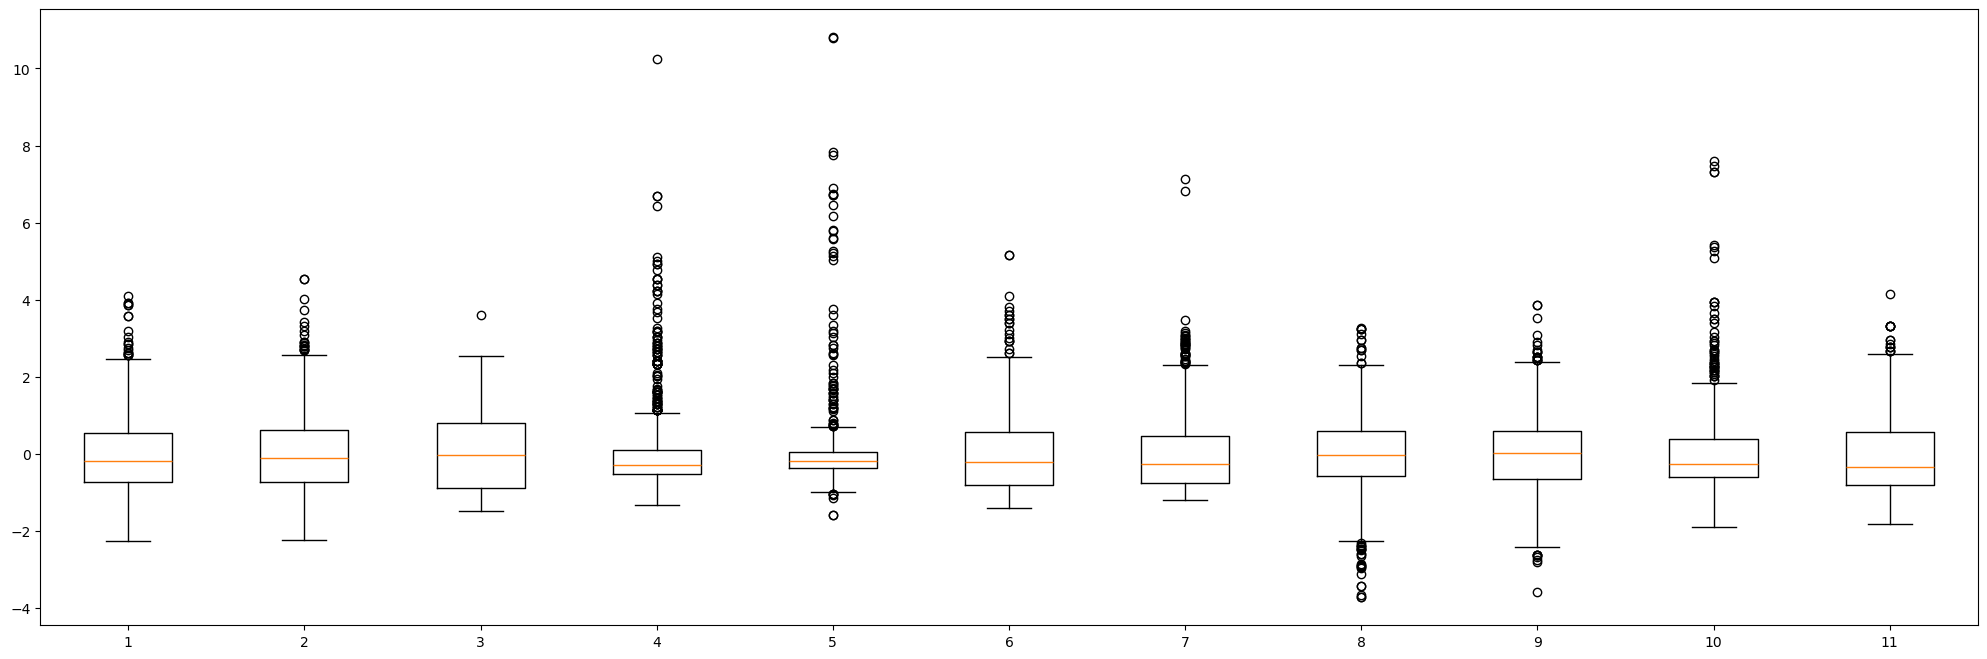

In [2]:
# reading in the multiclass data set
redwine_multiclass = pd.read_csv('redwine-multiclass.csv')
# seperating into our covariates/feratures and our response variable
# can get the response variable by just dropping the `quality` column (which is our response variable)
X = redwine_multiclass.drop('quality', axis=1)
# now get the response variable by just getting the `quality` column
Y = redwine_multiclass['quality']
# lets see what happends when we split the data manually
X_train = X.iloc[0:1200, :]
X_test = X.iloc[1200:, :]
Y_train = Y.iloc[0:1200]
Y_test = Y.iloc[1200:]

# standardise data - this is the same data as in Q1 with different labels, so we have the same need to standardise
mu = np.mean(X_train, axis=0)
sigma = np.std(X_train)
X_train = (X_train - mu) / sigma;
X_test = (X_test - mu) / sigma;
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(X_train);

Text(0.5, 1.0, 'Test data set')

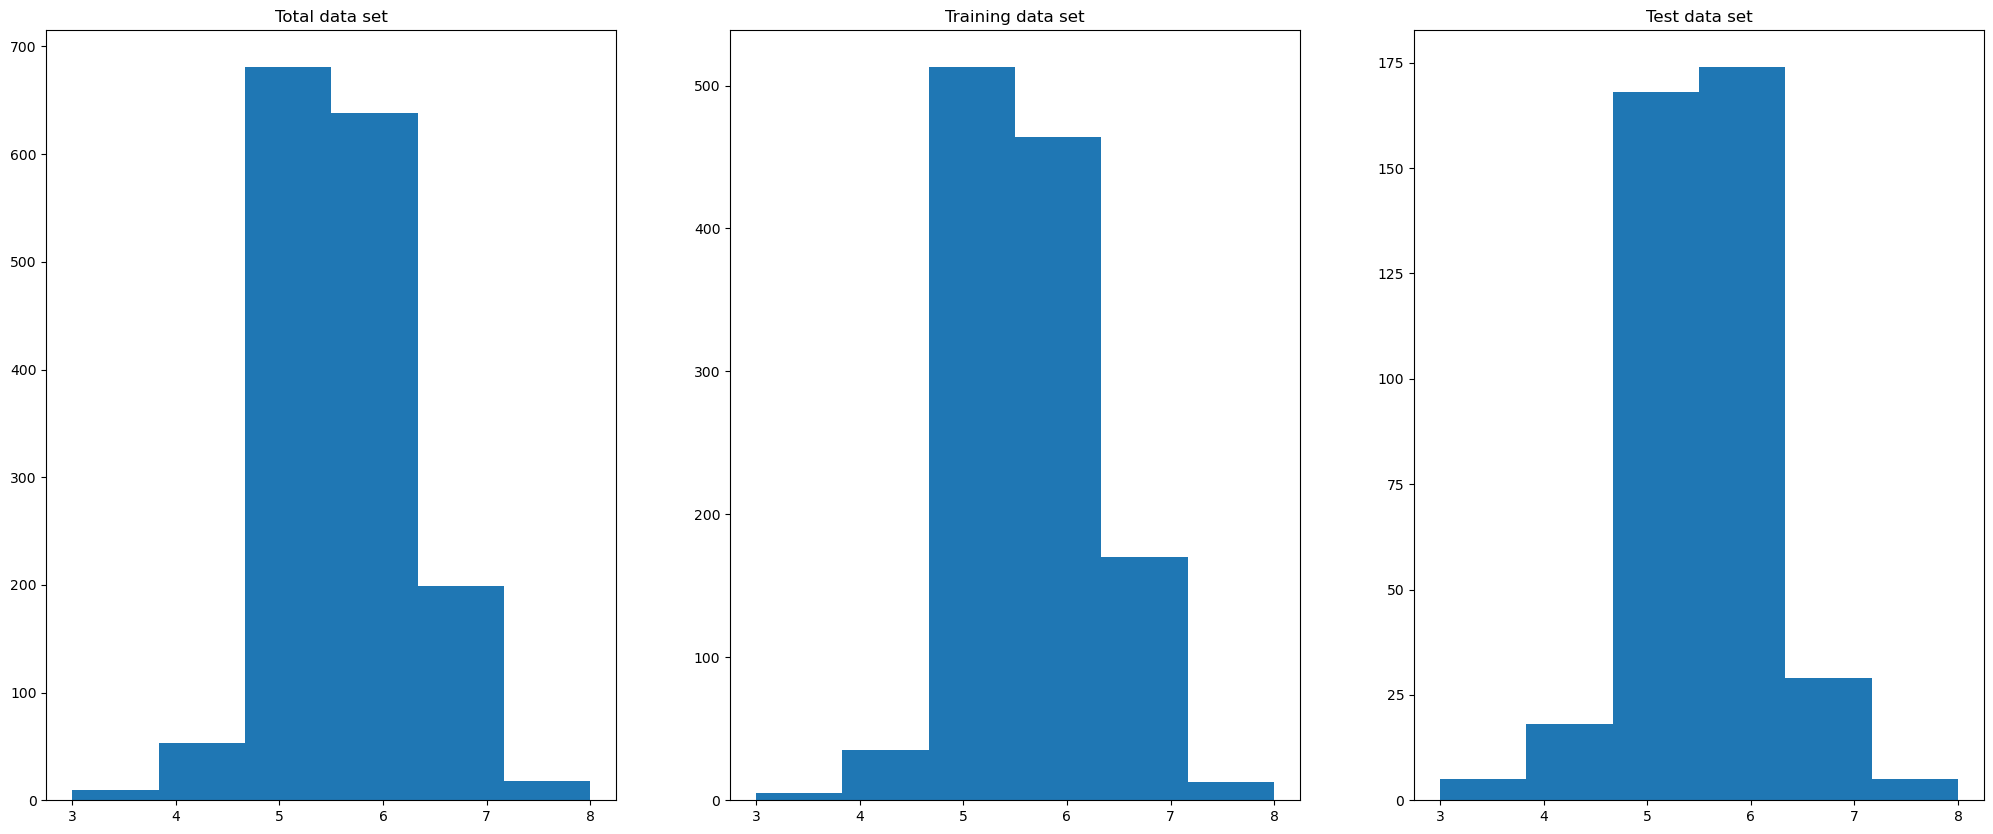

In [3]:
# having a look at class imbalance
fig = plt.figure(figsize=[25, 10])
ax = fig.add_subplot(1, 3, 1)
ax.hist(Y, 6)
ax.set_title('Total data set')
ax = fig.add_subplot(1, 3, 2)
ax.hist(Y_train, 6)
ax.set_title('Training data set')
ax = fig.add_subplot(1, 3, 3)
ax.hist(Y_test, 6)
ax.set_title('Test data set')

We have class imbalance - in quite a big way. Critically, we at least have all classes in both the training and testing sets, and both sets have a similar overall distribution to each other.

In [4]:
# helper function adapted from lecture examples

# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - get precision, recall, f1 for test data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance: %1.3f' % (sum(model.predict(X_train) == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Testing Set Performance: %1.3f' % (sum(model.predict(X_test) == Y_test)/len(Y_test)));
    print(classification_report(Y_test, model.predict(X_test)))

# Random Forest

First up, we'll try a random forest. Let's go with a simple model first and see what happens.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        18
           5       0.66      0.68      0.67       168
           6       0.59      0.73      0.65       174
           7       0.36      0.14      0.20        29
           8       0.00      0.00      0.00         5

    accuracy                           0.62       399
   macro avg       0.27      0.26      0.25       399
weighted avg       0.56      0.62      0.58       399



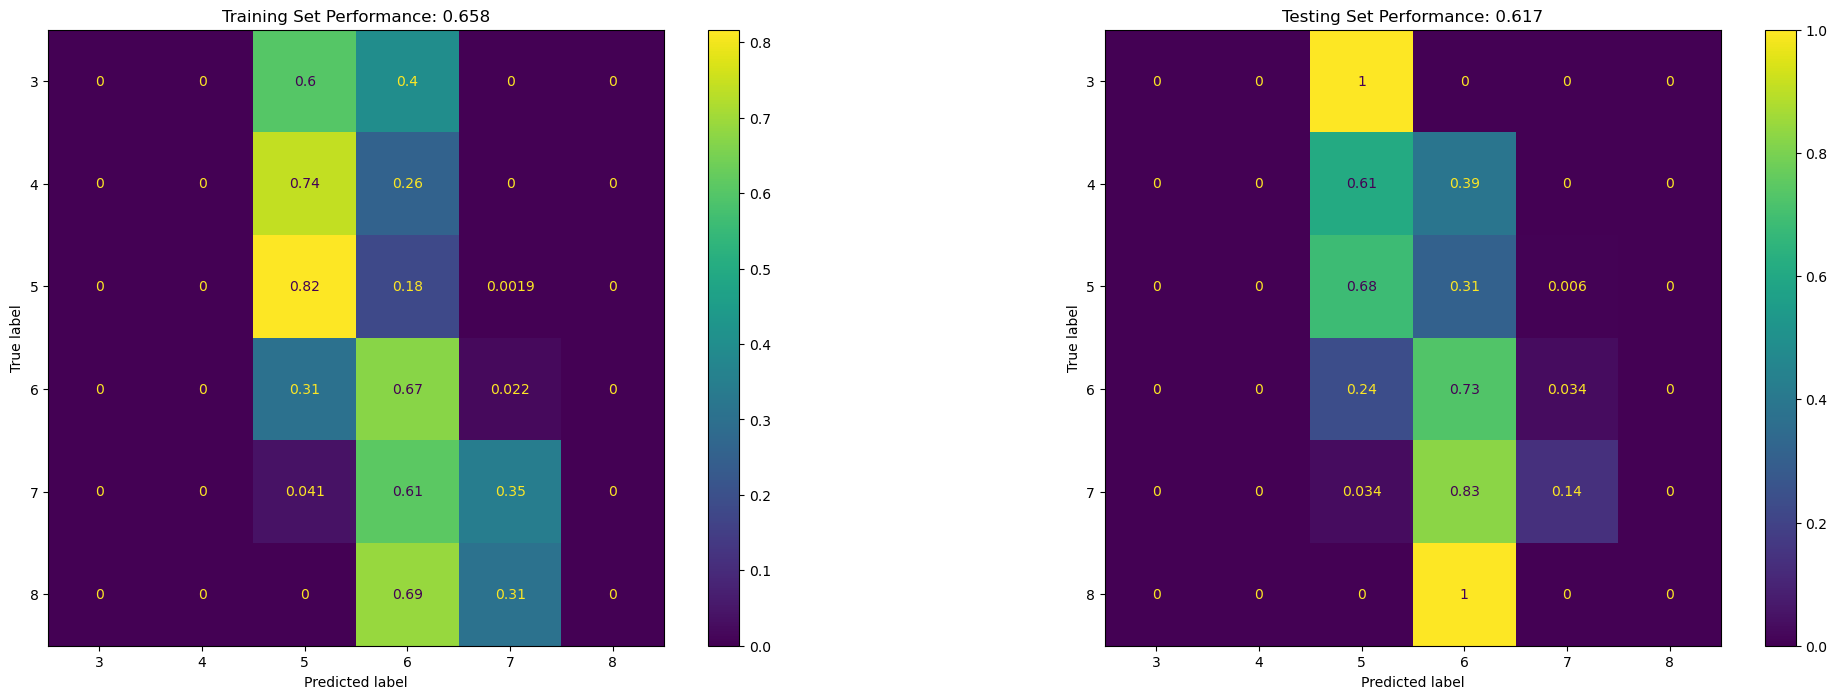

In [5]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0).fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

We have some class balance problems. We can try fix this by either:
* making our trees deeper
* setting class weights

Let's try both.

Note that for class weight, I'm going to use 'balanced_subsample' as we have such severe class imbalance and I want to ensure that each individual tree is balanced properly.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        18
           5       0.62      0.65      0.63       168
           6       0.58      0.66      0.61       174
           7       0.38      0.34      0.36        29
           8       0.00      0.00      0.00         5

    accuracy                           0.58       399
   macro avg       0.26      0.27      0.27       399
weighted avg       0.54      0.58      0.56       399



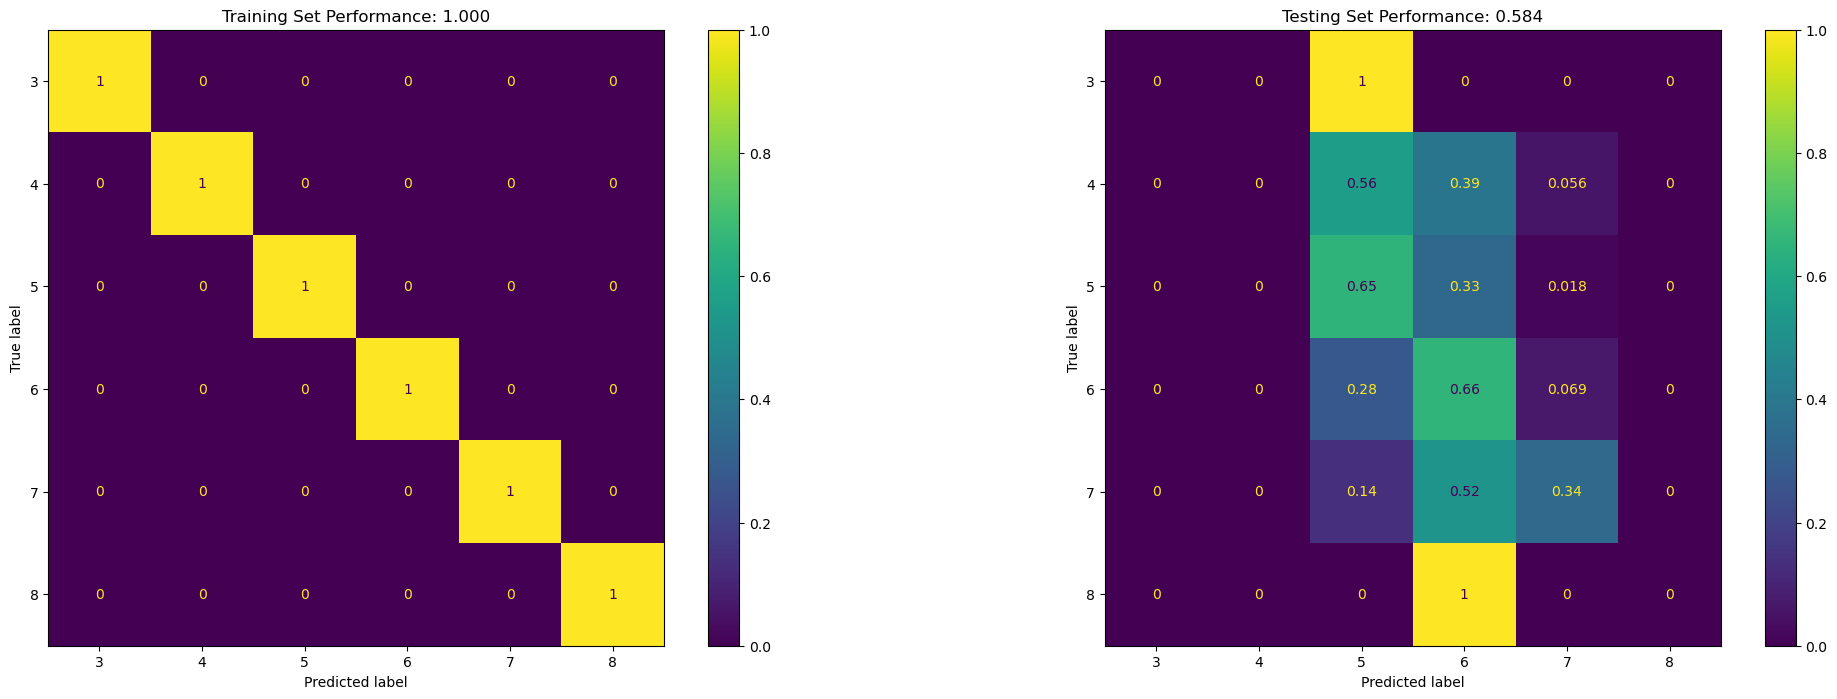

In [6]:
rf = RandomForestClassifier(n_estimators=100, max_depth=32, random_state=0).fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.14      0.56      0.22        18
           5       0.65      0.65      0.65       168
           6       0.70      0.22      0.34       174
           7       0.20      0.69      0.31        29
           8       0.17      0.20      0.18         5

    accuracy                           0.45       399
   macro avg       0.31      0.39      0.28       399
weighted avg       0.60      0.45      0.46       399



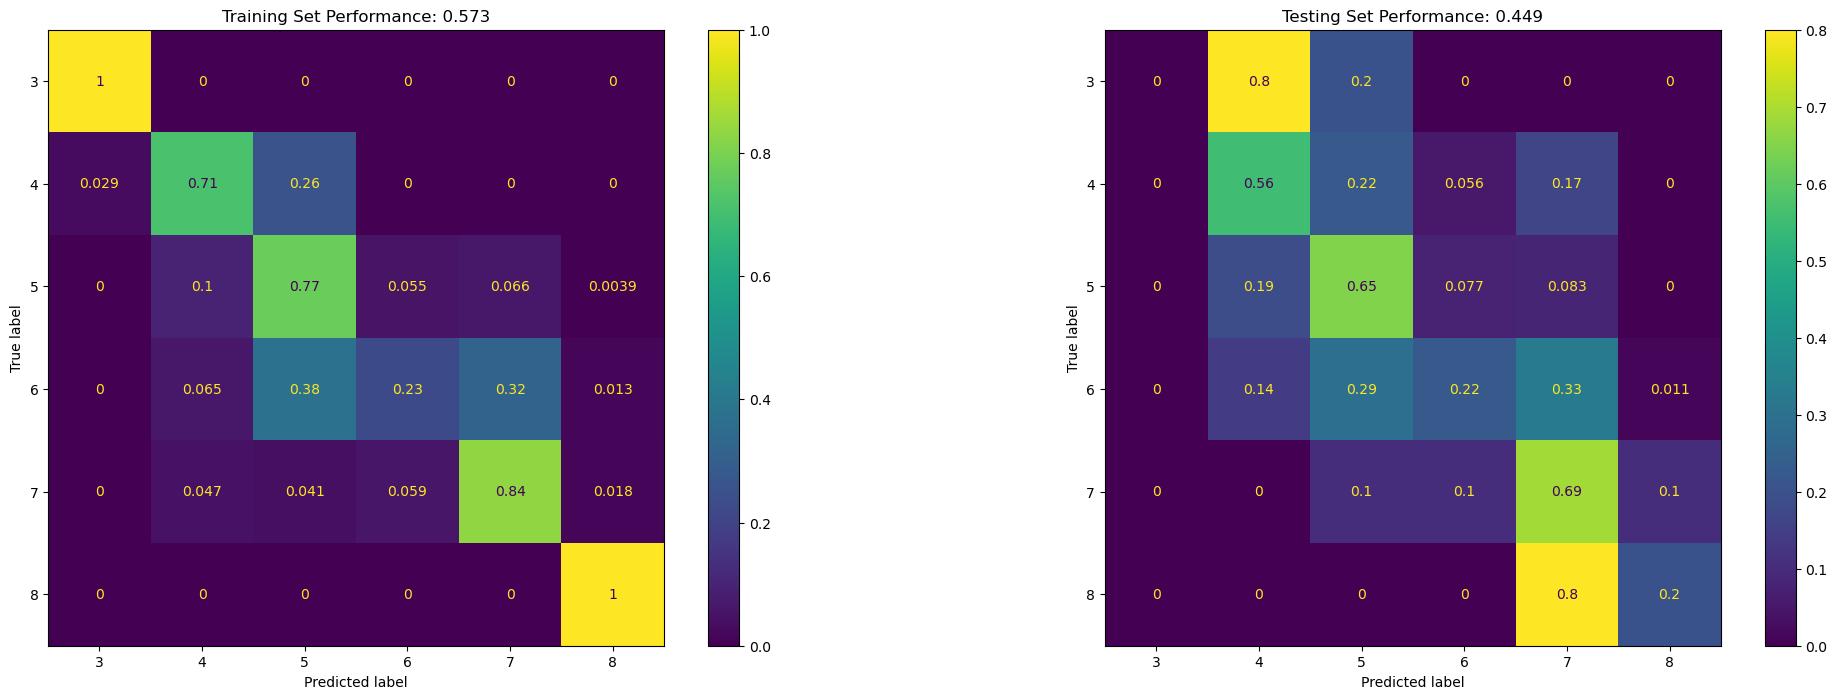

In [7]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0, class_weight='balanced_subsample').fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

In the end, my deeper tree has massively overfit, while my balanced tree has greatly improved performance on the rare classes, at the cost of the common ones.

If I increase the depth a little bit I can squeeze out some more performance.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.17      0.22      0.19        18
           5       0.67      0.68      0.67       168
           6       0.66      0.50      0.57       174
           7       0.27      0.69      0.39        29
           8       1.00      0.20      0.33         5

    accuracy                           0.57       399
   macro avg       0.46      0.38      0.36       399
weighted avg       0.61      0.57      0.57       399



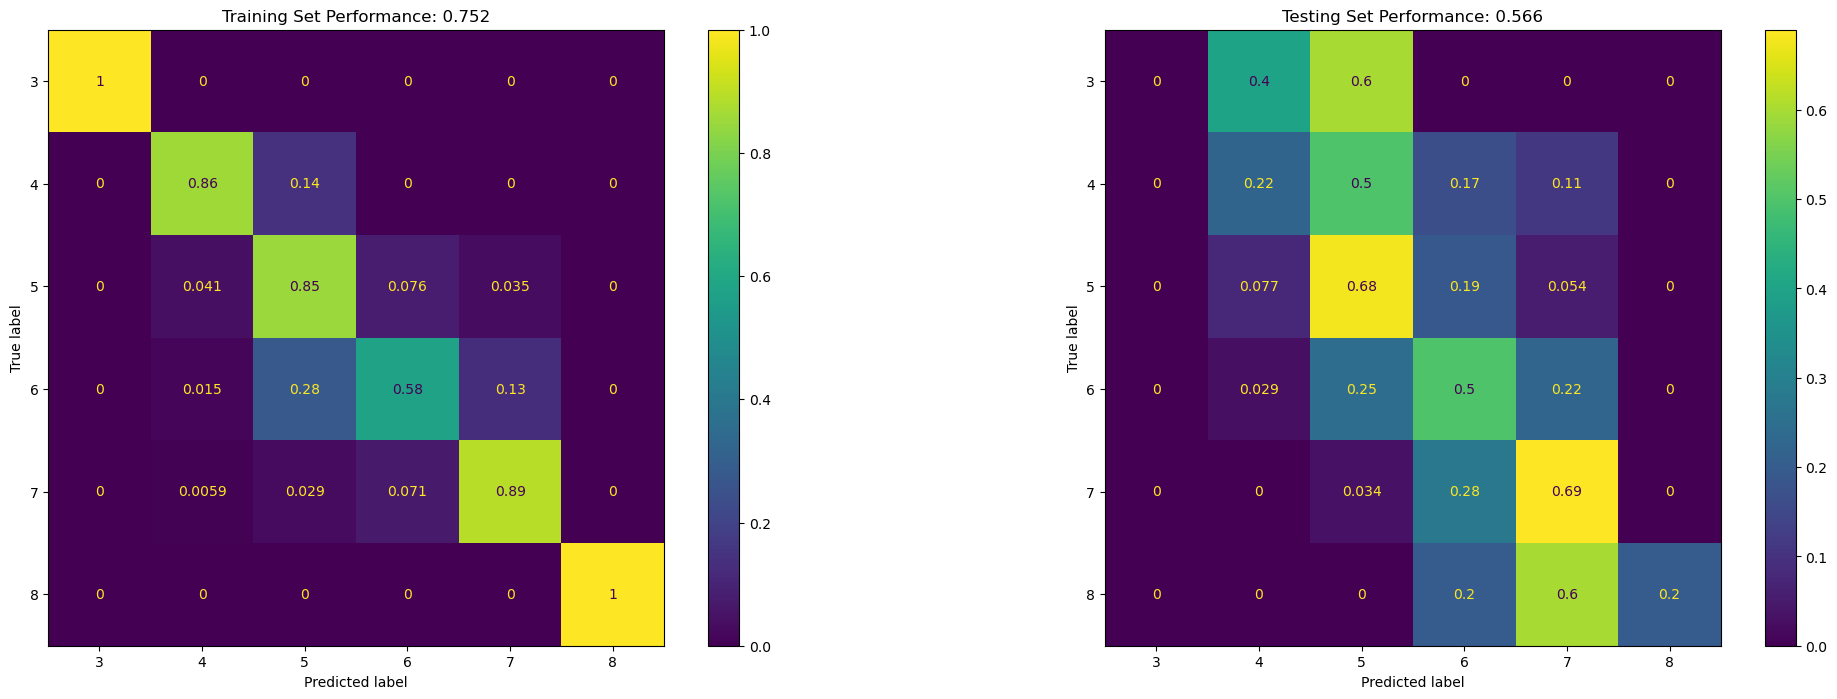

In [8]:
rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=0, class_weight='balanced_subsample').fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

As we go deeper, we can improve the test accuracy, but at the cost of the rare classes which we again start to lose.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.14      0.06      0.08        18
           5       0.66      0.70      0.68       168
           6       0.64      0.59      0.61       174
           7       0.35      0.66      0.45        29
           8       0.00      0.00      0.00         5

    accuracy                           0.60       399
   macro avg       0.30      0.33      0.30       399
weighted avg       0.59      0.60      0.59       399



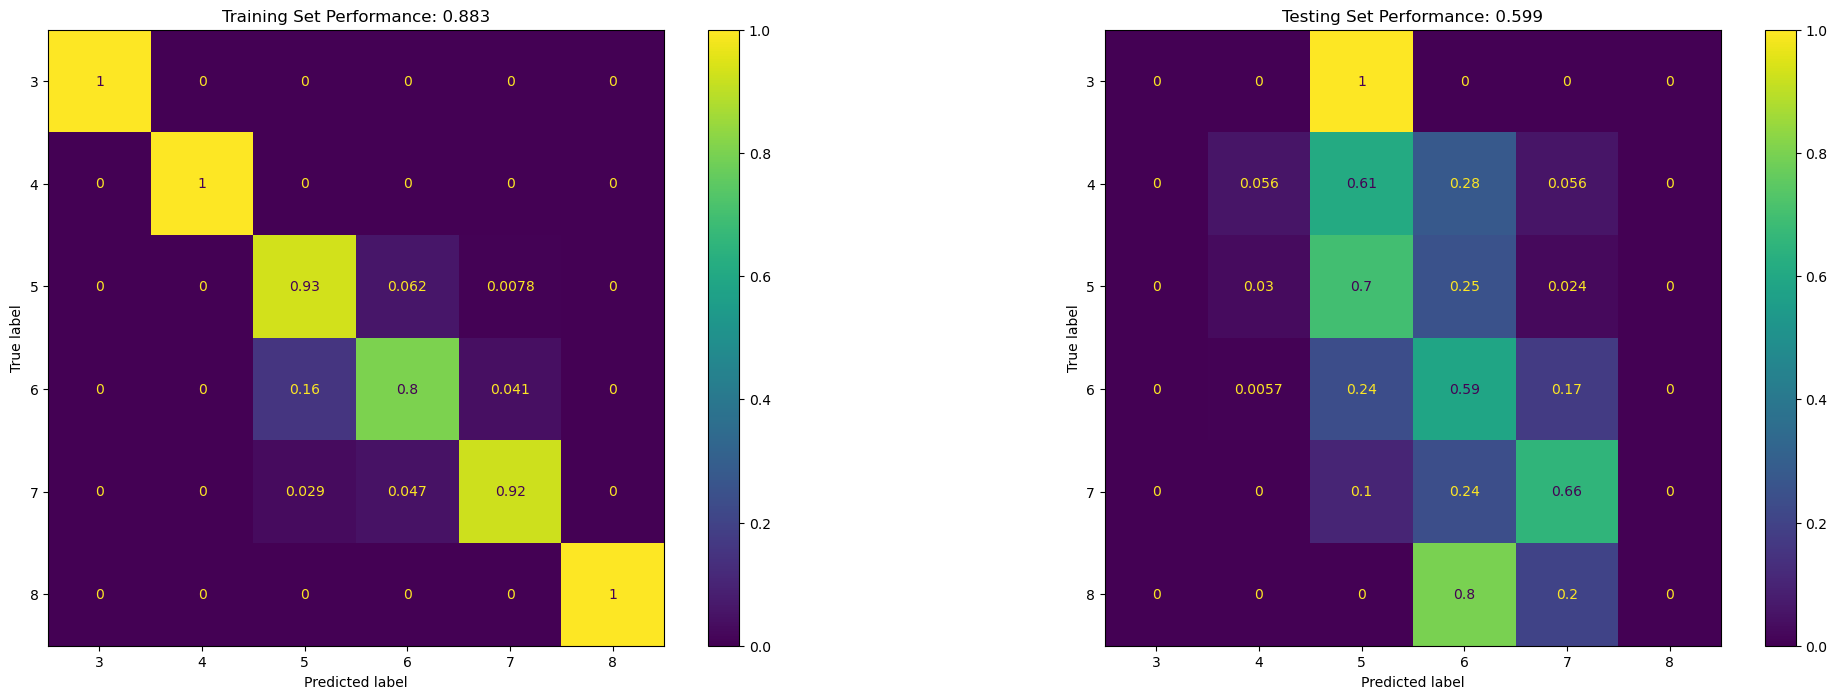

In [9]:
rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=0, class_weight='balanced_subsample').fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

We could continue to tune these and other parameters and perhaps eek out a bit more performance. One of the challenges however is how we consider our performance. It seems we can maximise performance by ignoring the minority classes - but does this make the model useful? If it can only detect two of the classes then it may have limited utility.

This also highlights a limitation of our accuracy measure. Raw accuracy doesn't really capture a lot of nuance when dealing with a multi-class problems. Thankfully, sklearn has a heap of metrics that we can play with. 

In [10]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.14      0.06      0.08        18
           5       0.66      0.70      0.68       168
           6       0.64      0.59      0.61       174
           7       0.35      0.66      0.45        29
           8       0.00      0.00      0.00         5

    accuracy                           0.60       399
   macro avg       0.30      0.33      0.30       399
weighted avg       0.59      0.60      0.59       399



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can get a nice little summary which gives more of picture of what's going on. You are encouraged to explore these metrics more in your own time.

# Ensemble of SVMs

## One vs. One

The sklearn SVM class will automatically extended itself to a 1v1 encoding when it get's shown multi-class data. it just does this

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        18
           5       0.64      0.68      0.66       168
           6       0.58      0.67      0.62       174
           7       0.35      0.21      0.26        29
           8       0.00      0.00      0.00         5

    accuracy                           0.60       399
   macro avg       0.26      0.26      0.26       399
weighted avg       0.55      0.60      0.57       399



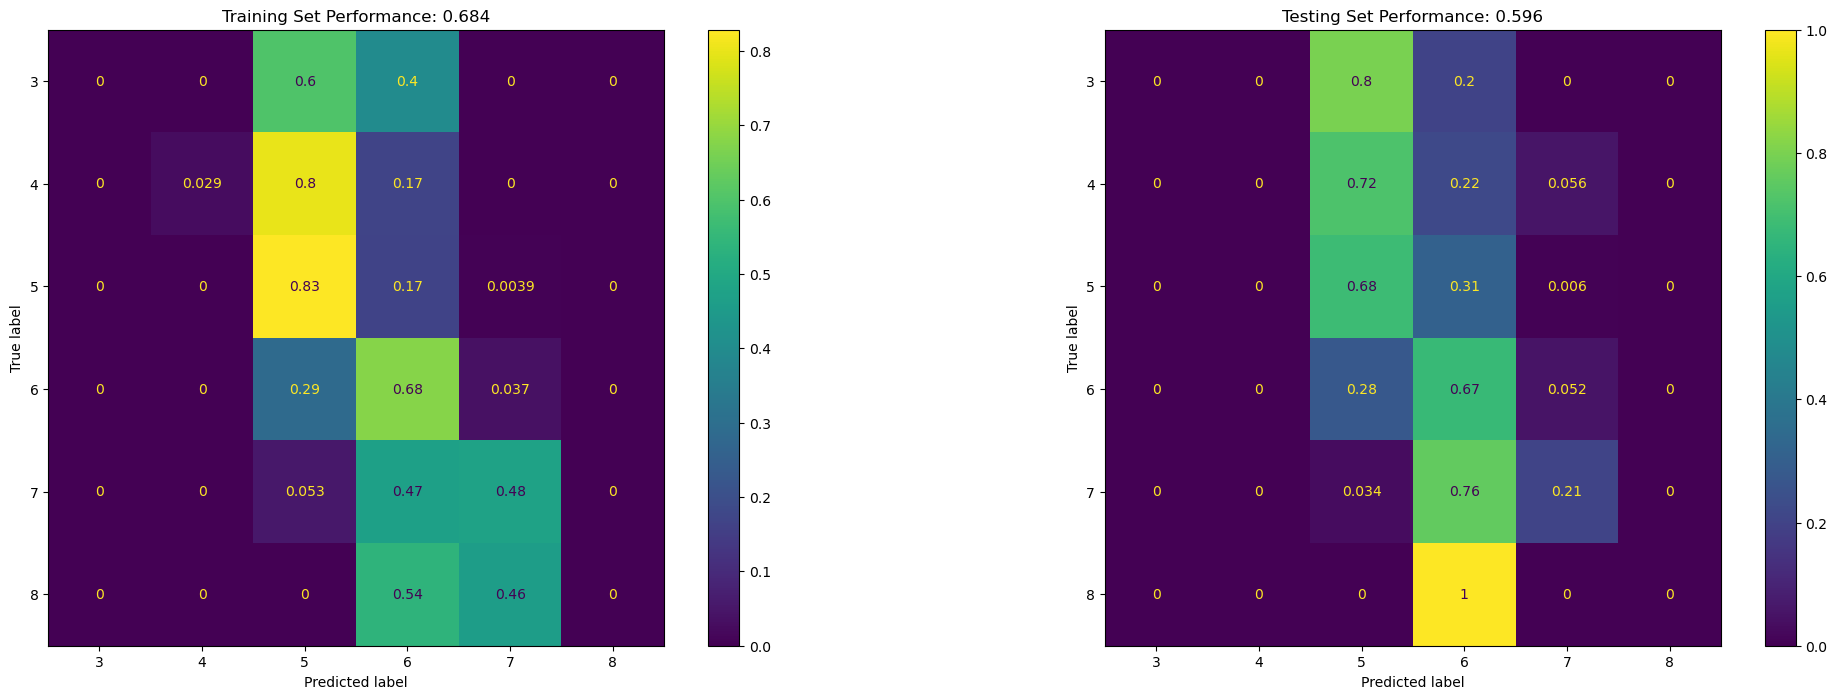

In [11]:
svm = SVC()
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

Pretty poor fit, but we know there is a huge class imbalance. Lets try and fix that a tad by applying class weights to increase the weight of undersampled classes.

As noted in the lecture example, with sklearn it's really easy to incorporate the class weights.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.16      0.50      0.24        18
           5       0.71      0.56      0.63       168
           6       0.58      0.48      0.52       174
           7       0.18      0.34      0.24        29
           8       0.09      0.20      0.13         5

    accuracy                           0.49       399
   macro avg       0.29      0.35      0.29       399
weighted avg       0.57      0.49      0.52       399



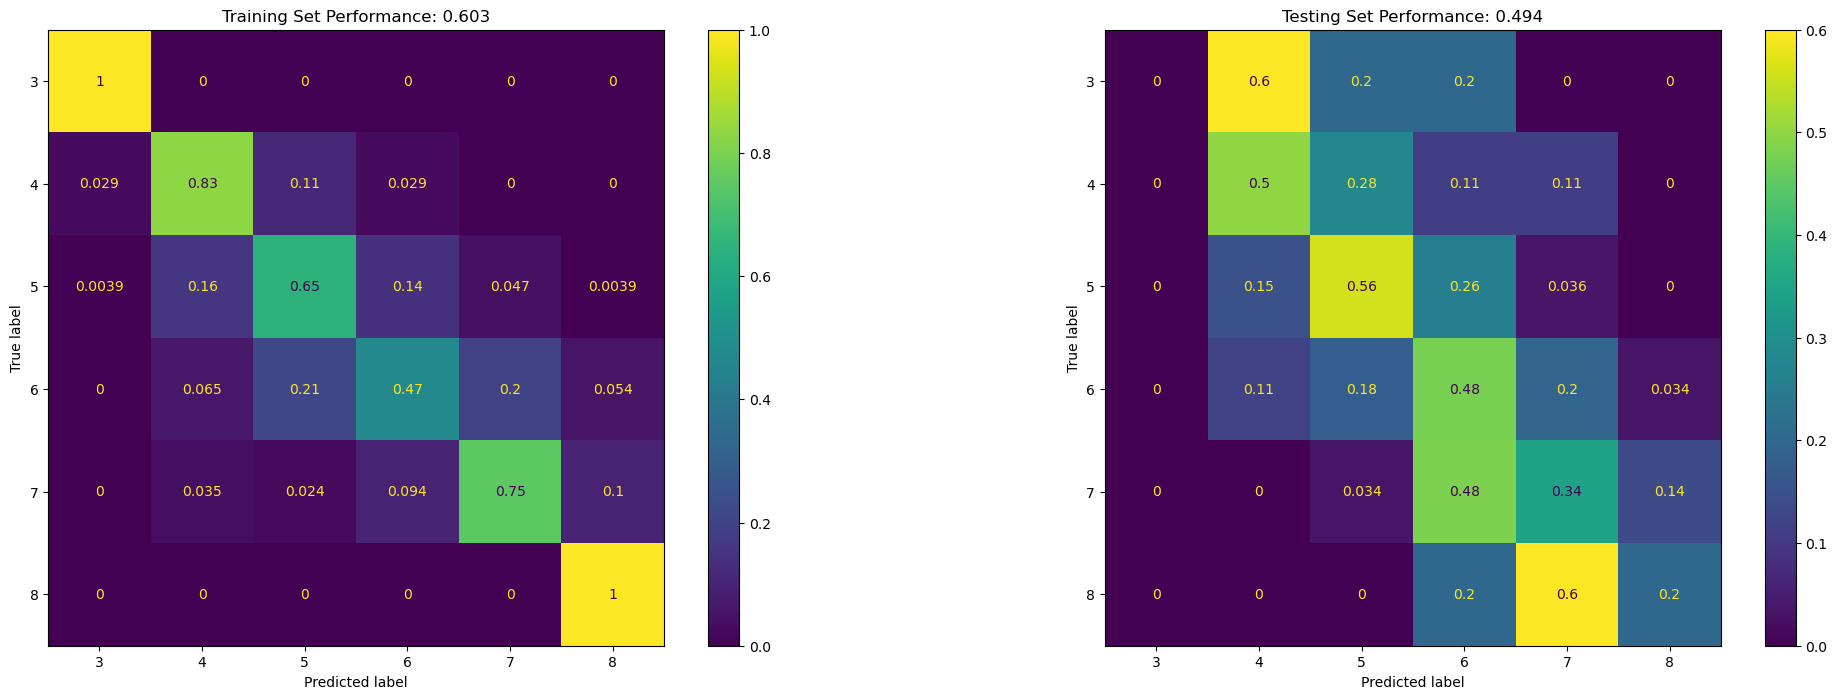

In [12]:
svm = SVC(class_weight='balanced')
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

This gives us mixed results:
* our classification rate drops (quite a bit)
* we can actually (sometimes) classify all classes, but not very well

Let's try a one vs all.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.21      0.28      0.24        18
           5       0.68      0.61      0.64       168
           6       0.59      0.61      0.60       174
           7       0.22      0.31      0.26        29
           8       0.00      0.00      0.00         5

    accuracy                           0.56       399
   macro avg       0.28      0.30      0.29       399
weighted avg       0.57      0.56      0.56       399



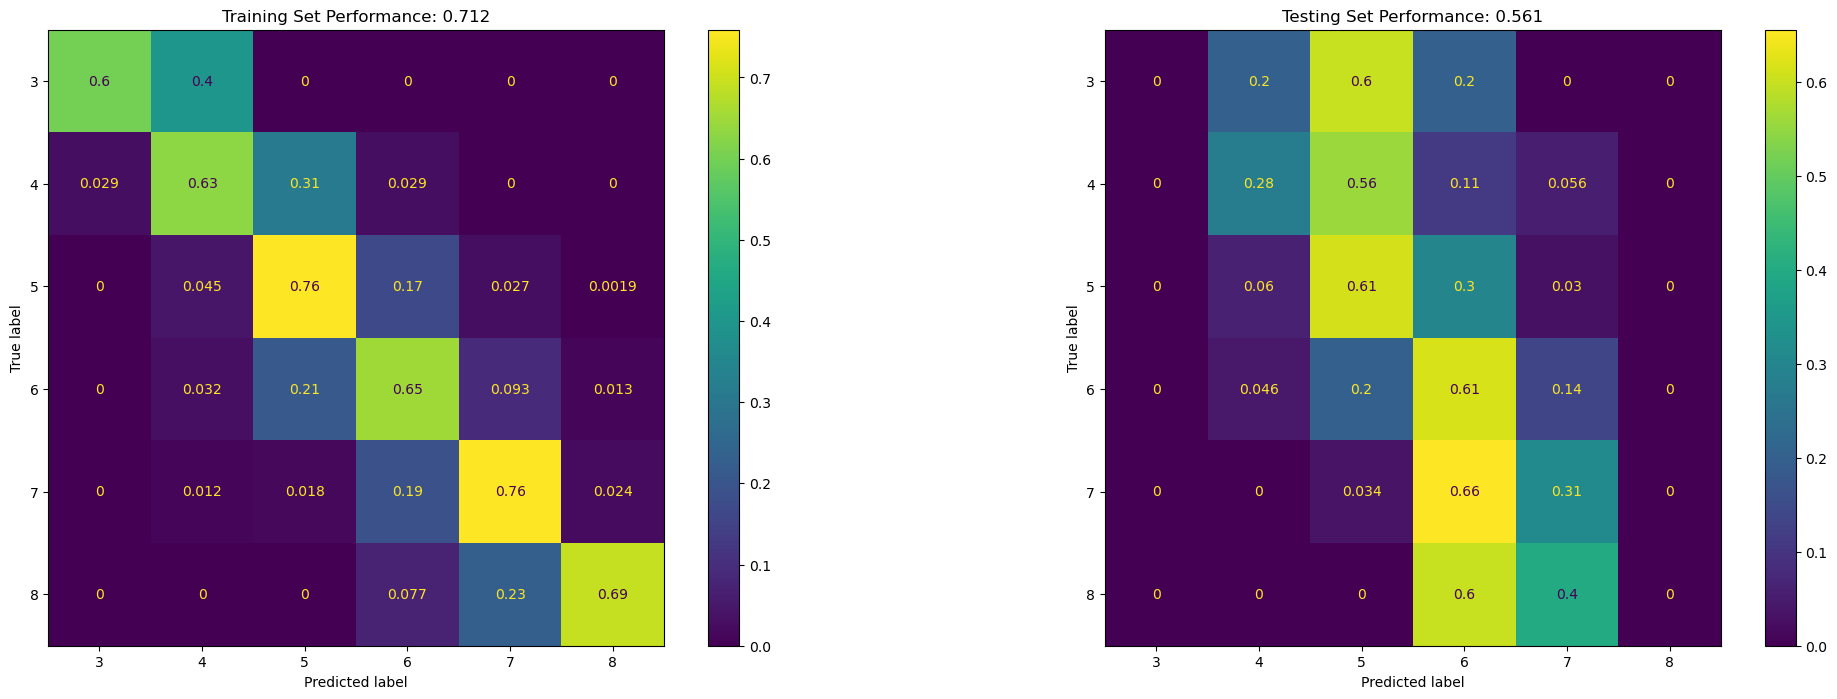

In [13]:
onevsall_svm = OneVsRestClassifier(SVC(class_weight='balanced'))
onevsall_svm.fit(X_train, Y_train)
eval_model(onevsall_svm, X_train, Y_train, X_test, Y_test)

This is a bit better, but still not great. At this point it's worth considering if we have the right hyperparameters for our SVMs. The next steps in optimising this would be to perform a grid search for different SVM parameters. In particular looking at values of C and the kernels. Let's do this for a one vs one SVM with class weights.

In [14]:
param_grid = [
  {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100], 'degree': [3, 4, 5], 'kernel': ['poly']},
 ]
svm = SVC(class_weight='balanced')
grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(X_train, Y_train)
grid_search.cv_results_

{'mean_fit_time': array([0.02409492, 0.03193388, 0.10124774, 0.70401731, 0.04543967,
        0.05354571, 0.05666118, 0.03191342, 0.03744755, 0.05223141,
        0.03009686, 0.03152547, 0.03750038, 0.0437686 , 0.03710365,
        0.03329725, 0.03451805, 0.03762622, 0.0376421 , 0.02852564,
        0.03197908, 0.03274574, 0.03295484, 0.03188806, 0.03235497,
        0.08198013, 0.04658809, 0.04119258]),
 'std_fit_time': array([0.00013314, 0.00108368, 0.00550817, 0.09210672, 0.00033115,
        0.00027639, 0.00036605, 0.00045627, 0.00046234, 0.00026705,
        0.00041418, 0.00040995, 0.00029044, 0.00075259, 0.00129815,
        0.00041928, 0.00054584, 0.00056248, 0.00099259, 0.0005679 ,
        0.00076391, 0.000665  , 0.0003152 , 0.00034687, 0.0007871 ,
        0.01487401, 0.00304255, 0.00156507]),
 'mean_score_time': array([0.00452566, 0.00446253, 0.00468645, 0.00466385, 0.01083074,
        0.01093011, 0.01088405, 0.0103116 , 0.01145744, 0.01146922,
        0.00947938, 0.01002035, 0.010433

{'C': 1, 'degree': 3, 'kernel': 'poly'}


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       1.00      0.20      0.33         5
           4       0.00      0.00      0.00        18
           5       0.62      0.71      0.66       168
           6       0.61      0.65      0.63       174
           7       0.29      0.17      0.22        29
           8       0.00      0.00      0.00         5

    accuracy                           0.60       399
   macro avg       0.42      0.29      0.31       399
weighted avg       0.56      0.60      0.57       399



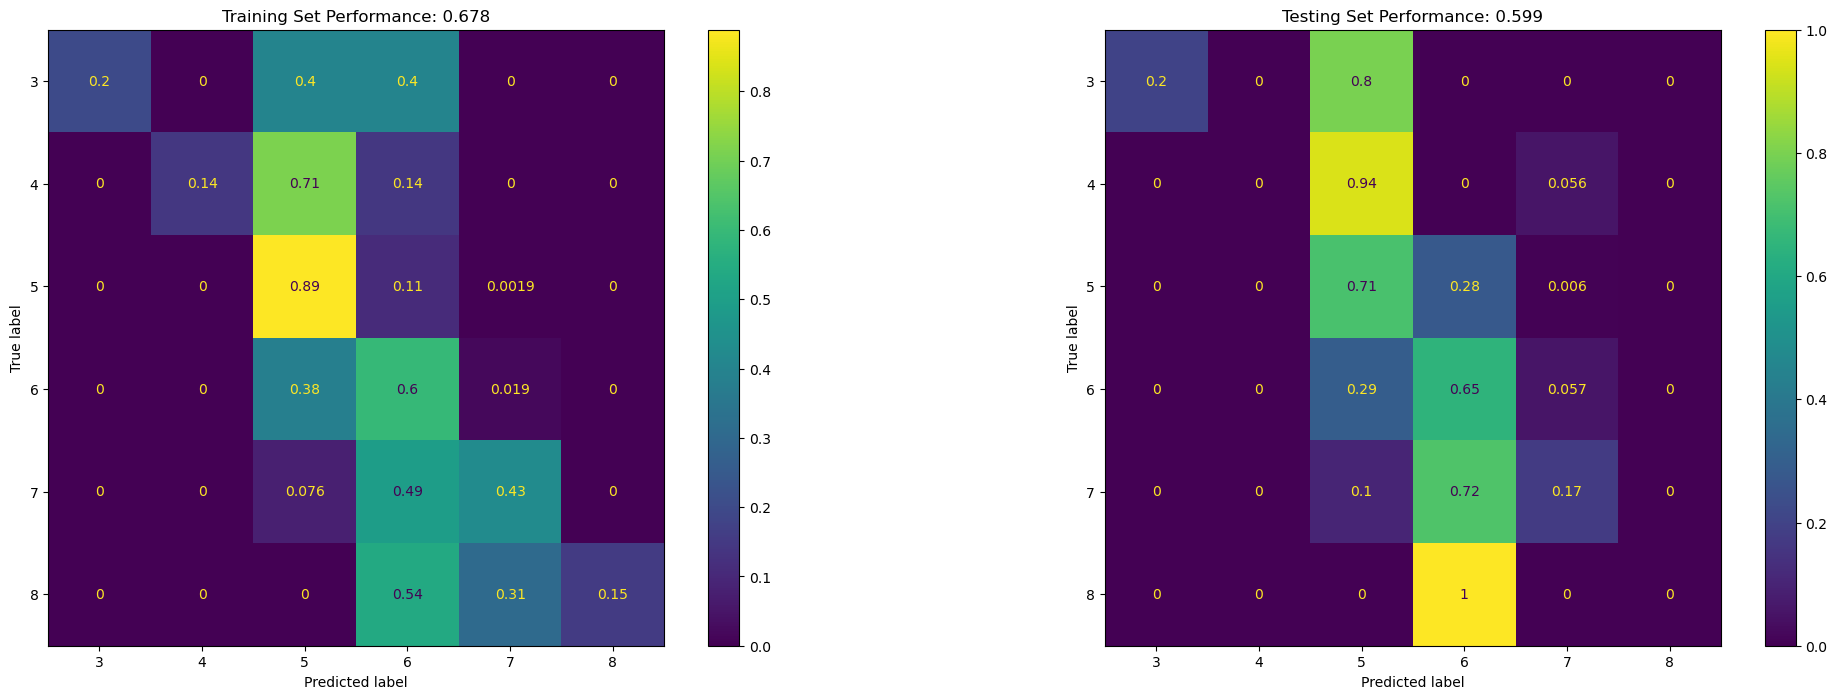

In [15]:
best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
svm = SVC().set_params(**params)
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

This works a bit better, and seems to be heading in the right direction.

Our best performing model is actually a polynomial kernel, which would perhaps not be our first choice. That said, we've used a fairly limited and quite coarse grid, so we could certainly try a lot of other options and perhaps improve on this further.

## Bonus: CKNN
Let's finish up with a CKNN, and an arbitrary number of neighbours.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        18
           5       0.59      0.60      0.59       168
           6       0.56      0.67      0.61       174
           7       0.30      0.24      0.27        29
           8       0.00      0.00      0.00         5

    accuracy                           0.56       399
   macro avg       0.24      0.25      0.25       399
weighted avg       0.52      0.56      0.53       399



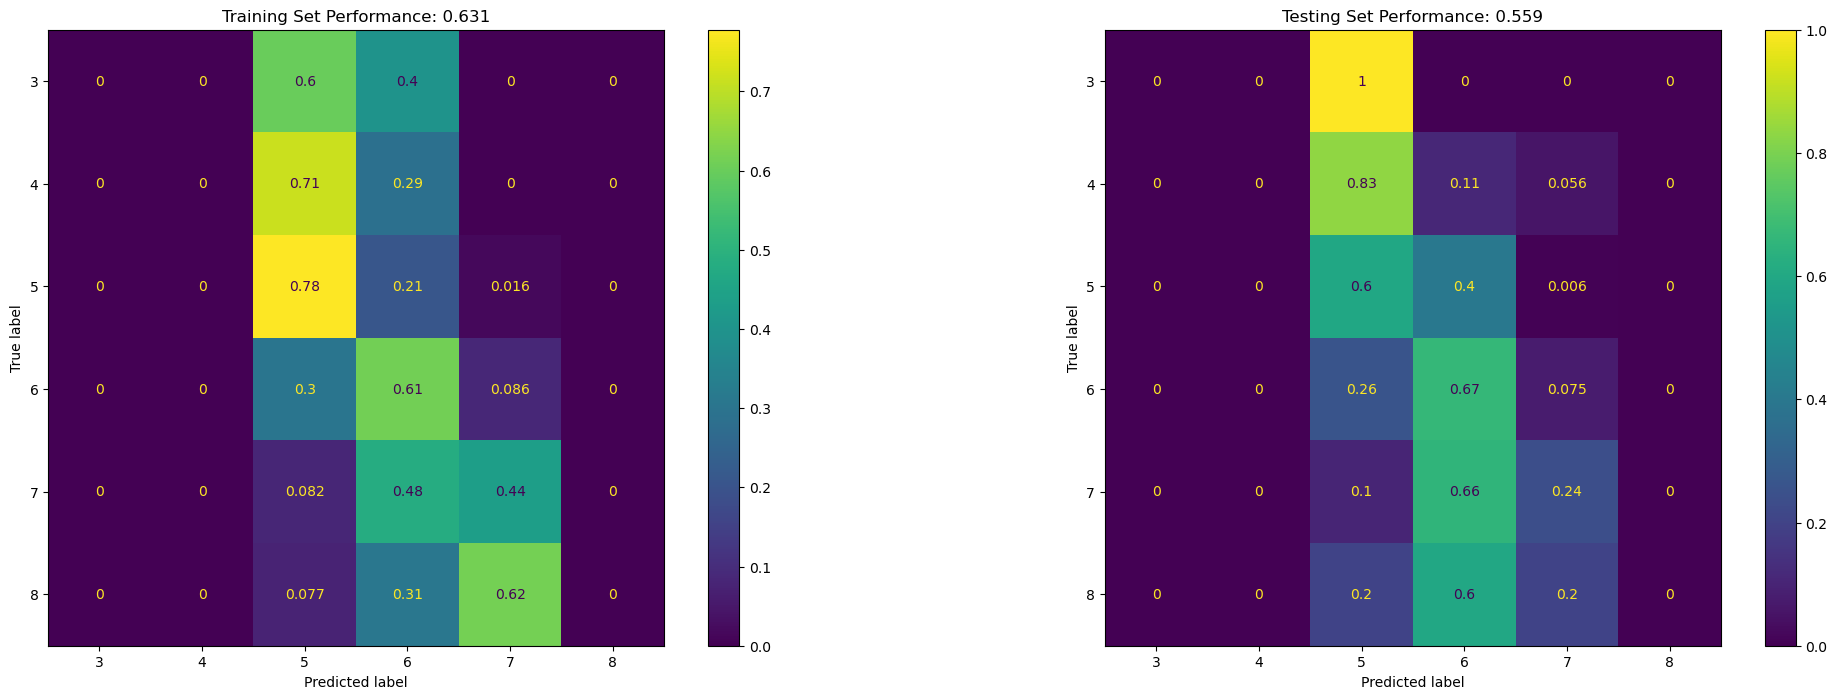

In [16]:
cknn = KNeighborsClassifier(n_neighbors=20)
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

It's fair to say, this goes badly. We have massive class imbalance as seen above, so need to reduce the 'NumNeighbors' parameter to increase the chance of being able to get these rare classes right. If we have this too big, then by virtue of a lack of sample points, these rare classes will always be classified as something else simply becuase there are not enough points.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.09      0.11      0.10        18
           5       0.55      0.64      0.59       168
           6       0.53      0.46      0.49       174
           7       0.23      0.21      0.22        29
           8       0.00      0.00      0.00         5

    accuracy                           0.49       399
   macro avg       0.23      0.24      0.23       399
weighted avg       0.48      0.49      0.48       399



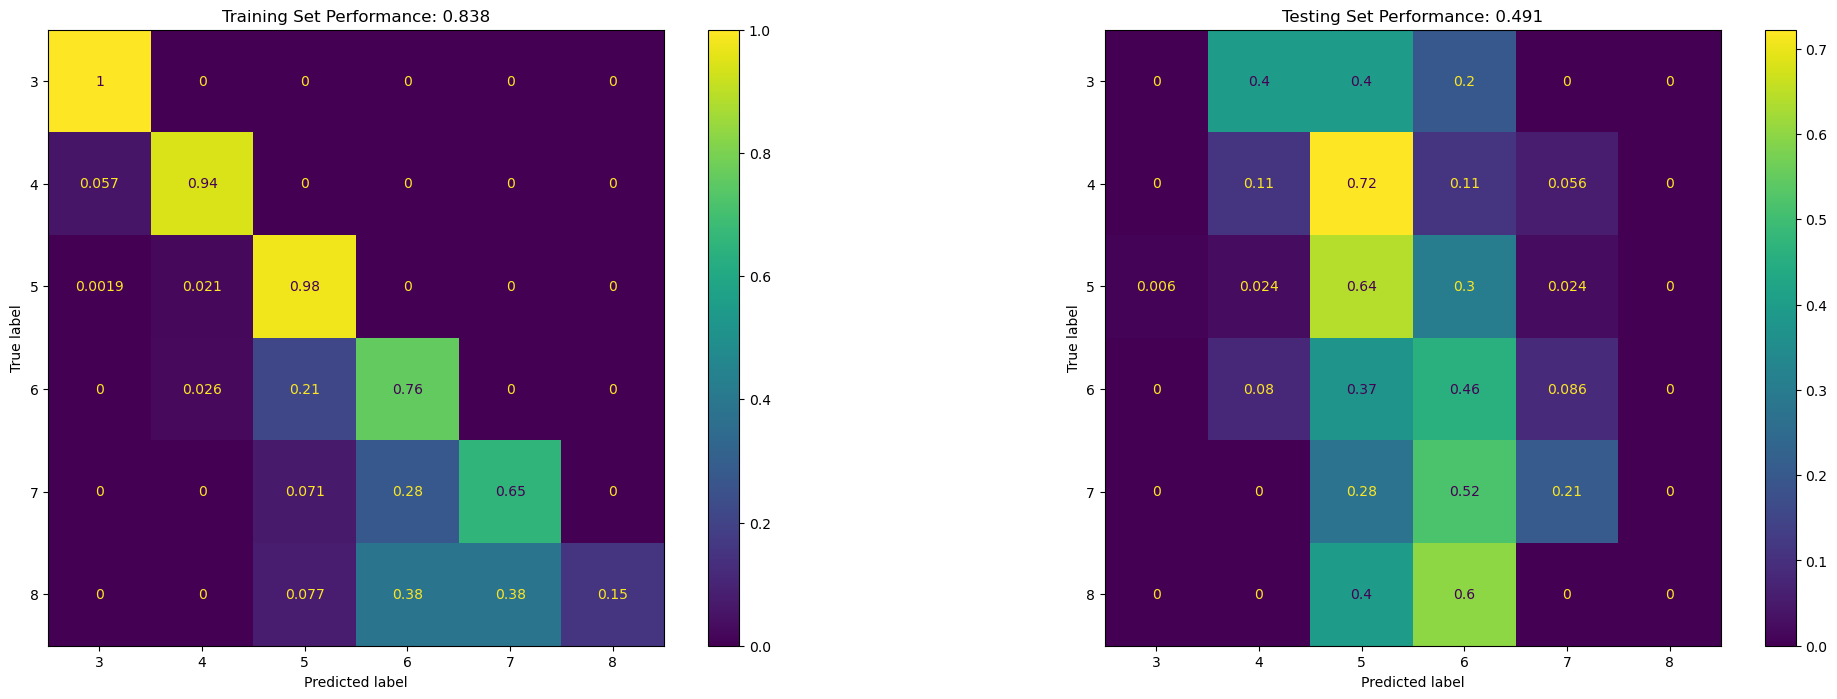

In [17]:
cknn = KNeighborsClassifier(n_neighbors=2)
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

This has improved our results slightly - but not that much really. That said, our confusion matrix looks much more promising, even if the overall accuracy is still poor.